In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize 
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def split_border(Nodes,N,closed=False):
    points_x = np.array([])
    points_y = np.array([])
    for i in range(Nodes.shape[0]-2):
        points_x = np.append(points_x, np.linspace(Nodes[i,0],Nodes[i+1,0],N[i])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[i,1],Nodes[i+1,1],N[i])[:-1])
        
    if not closed:   
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1]))
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1]))
    if closed:
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1])[:-1])
    
    
    return np.hstack((points_x.reshape(-1,1),points_y.reshape(-1,1)) )

In [3]:
def create_arc(c,r,a1,a2,s):
    alpha = np.radians(np.linspace(a1,a2,s))
    x = r*np.cos(alpha) + c[0]
    y = r*np.sin(alpha) + c[1]
    
    return np.hstack((x.reshape(-1,1),y.reshape(-1,1)) )

In [4]:
def tilt_square_vert(c,w):
    dd = np.sqrt(2.)/2.
    L_out = w
    points_delta = np.array([[0,dd*L_out],
                           [dd*L_out,0],
                           [0,-dd*L_out],
                           [-dd*L_out,0]])
    points_out = np.tile(c,(4,1))+points_delta

    return points_out    

In [5]:
def create_rounded_square(points,R,s_arc,s_line,mask_data = True):
    dd = np.sqrt(2)
    deltas = np.array([[0,-dd*R],
                       [-dd*R,0],
                       [0,dd*R],
                       [dd*R,0]])
    centers = points + deltas
    angles = np.array([[135.,45.],
                       [45.,-45.],
                       [-45.,-135.],
                       [225.,135.]])
    
    arcs = []
    for c, a in zip(centers,angles):
        arcs.append(create_arc(c,R,a[0],a[1],s_arc))
    lines = []
    for i in range(len(arcs)-1):
        lines.append(split_border(np.array([arcs[i][-1],arcs[i+1][0]]),[s_line])[1:-1])
        #lines.append(np.linspace(arcs[i][-1],arcs[i+1][0],s_line)[1:-1])
    lines.append(split_border(np.array([arcs[-1][-1],arcs[0][0]]),[s_line])[1:-1])
    rez = np.vstack((arcs[0],lines[0],arcs[1],lines[1],arcs[2],lines[2],arcs[3],lines[3]))
    if mask_data:
        arcs = np.array(arcs)
        rect1 = np.hstack((arcs[[0,2],-1,:],arcs[[1,3],0,:])).reshape(-1,2)
        rect2 = np.hstack((arcs[[0,2],0,:],arcs[[1,3],-1,:])).reshape(-1,2)
        return centers, rect1, rect2, rez 
    return rez

In [6]:
def enclose(points):
    return np.vstack((points,points[0]))

In [279]:
def create_fig(L,W):
    #import pdb;pdb.set_trace()
    L_out = 150
    s_out = [40]*4
    c1 = np.array([0,0])
    points_out = tilt_square_vert(c1,L_out)
    nodes_out = split_border(enclose(points_out),s_out,closed=True)
    
    points_left = tilt_square_vert(c1+[-L/2,0],W)
    points_right = tilt_square_vert(c1+[L/2,0],W)
    R1 = 10
    k1 = 0.3
    k2 = 1.2
    centers1,rect11,rect12,nodes_left = create_rounded_square(points_left,R1,int(np.pi*R1*k2/4),int(W*k1))
    centers2,rect21,rect22,nodes_right = create_rounded_square(points_right,R1,int(np.pi*R1*k2/4),int(W*k1))
    s_mesh = 40
    delta = 1
    X,Y = np.meshgrid(np.linspace(-L_out/2+delta,L_out/2-delta,s_mesh),np.linspace(-L_out/2+delta,L_out/2-delta,s_mesh))
    RotRad = np.pi/4.
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                      [-np.sin(RotRad), np.cos(RotRad)]])
    X1,Y1 = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([X, Y]))
    del X,Y
    inner = np.vstack((X1.ravel(),Y1.ravel())).T
    '''
    masks_rect = [True]*inner.shape[0]
    for rect in [rect11,rect12,rect21,rect22]:
        masks_rect = masks_rect & np.logical_not(in_rect(rect,delta,inner))
    masks_circ = [True]*inner.shape[0]
    for center in np.vstack((centers1,centers2)):
        masks_circ = masks_circ & np.logical_not(in_circle(inner,center,R1,delta))
    inner = inner[masks_rect & masks_circ]
    '''
    
    mask1 = not_in_sq_rect([rect11,rect12],centers1,1.,R1,inner)
    mask2 = not_in_sq_rect([rect21,rect22],centers2,1.,R1,inner)
    inner = inner [mask1 & mask2]
    Nodes = np.vstack((nodes_out,nodes_left,nodes_right,inner))
    simplices = scipy.spatial.Delaunay(Nodes).simplices
    trng_centers = np.hstack((np.mean(Nodes[simplices][:,:,0],axis=1).reshape(-1,1),
                              np.mean(Nodes[simplices][:,:,1],axis=1).reshape(-1,1)))
    mask3 = not_in_sq_rect([rect11,rect12],centers1,0.0,R1,trng_centers)
    mask4 = not_in_sq_rect([rect21,rect22],centers2,0.0,R1,trng_centers)
    simplices = simplices[mask3 & mask4]
    Area = (L_out)**2-2*(np.pi*R1**2+(W-R1)**2+
            4*(np.linalg.norm(centers1[0]-centers1[1])*np.linalg.norm(centers1[0]-rect11[0])))
    forced = np.arange(s_out[0])
    fixed = np.arange(s_out[0]*2-2,s_out[0]*3-2)
    
    return Nodes, simplices, Area,fixed,forced

In [73]:
def show_parts(*parts):
    plt.figure(figsize=(14,14))
    plt.grid(True)
    
    for part in parts:
        plt.plot(part[:,0],part[:,1],'.',c='b',markersize=3)
    plt.axis('equal')

In [74]:
def line(p1,p2,x):
    return p1[1]+(p2[1]-p1[1])*((x-p1[0])/(p2[0]-p1[0]))

In [75]:
def in_rect(rect,k,arr):
    gn1 = line(rect[0],rect[1],arr[:,0])>arr[:,1]+np.full_like(arr[:,1],-k)
    gn2 = line(rect[1],rect[2],arr[:,0])<arr[:,1]+np.full_like(arr[:,1],k)
    gn3 = line(rect[2],rect[3],arr[:,0])<arr[:,1]+np.full_like(arr[:,1],k)
    gn4 = line(rect[3],rect[0],arr[:,0])>arr[:,1]+np.full_like(arr[:,1],-k)
    return gn1 & gn2 & gn3 & gn4

In [76]:
def in_circle(inner, circ_center, radius,delta):
    mask = np.sum(np.power(inner - circ_center, 2), axis=1) < np.power(radius+delta, 2)
    return mask

In [77]:
def not_in_sq_rect(rects,cents,delta,r,arr):
    masks_rect = [True]*arr.shape[0]
    for rect in rects:
        masks_rect = masks_rect & np.logical_not(in_rect(rect,delta,arr))
    masks_circ = [True]*arr.shape[0]
    for center in cents:
        masks_circ = masks_circ & np.logical_not(in_circle(arr,center,r,delta))
    return masks_rect & masks_circ

In [280]:
ar1, sr1,a1,fi1,fo1 = create_fig(90,40)

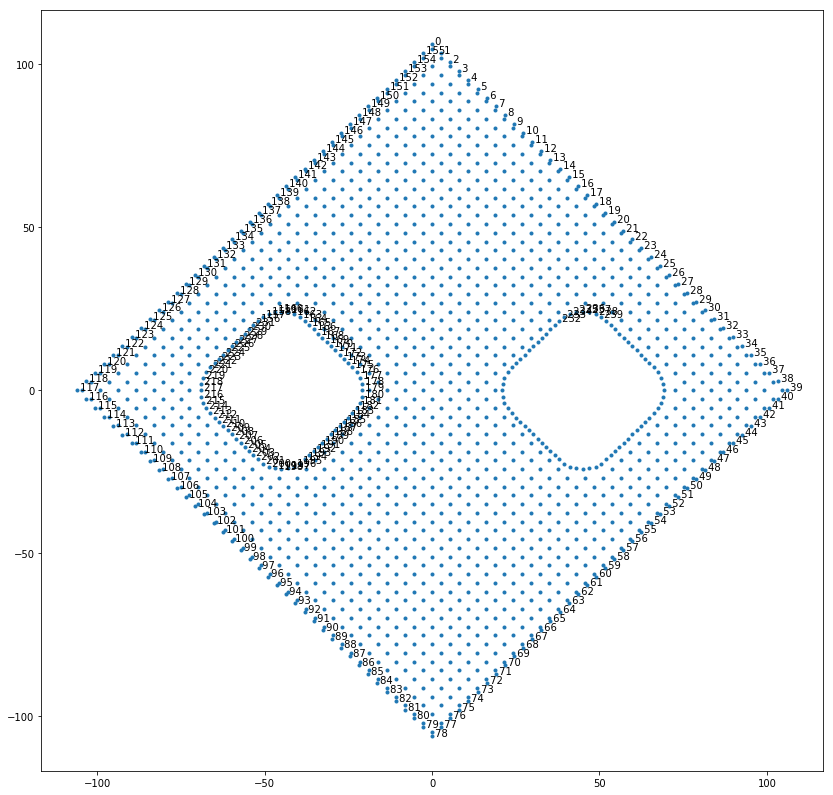

In [281]:
plt.figure(figsize=(14,14))
plt.plot(ar1[:,0],ar1[:,1],'.')
for i, p in enumerate(ar1[:240]):
    plt.text(p[0],p[1],' %d'%i)

In [282]:
fi1

array([ 78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])

In [283]:
fo1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

(-116.67261889578035,
 116.67261889578035,
 -116.67261889578035,
 116.67261889578035)

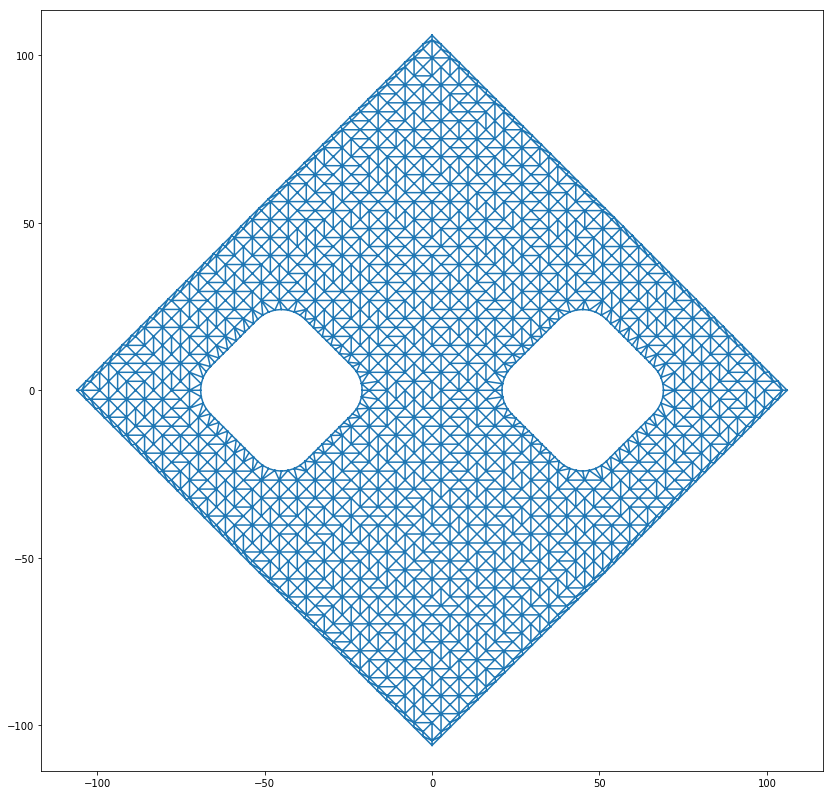

In [284]:
plt.figure(figsize=(14,14))
plt.triplot(ar1[:,0],ar1[:,1],sr1)
plt.axis('equal')

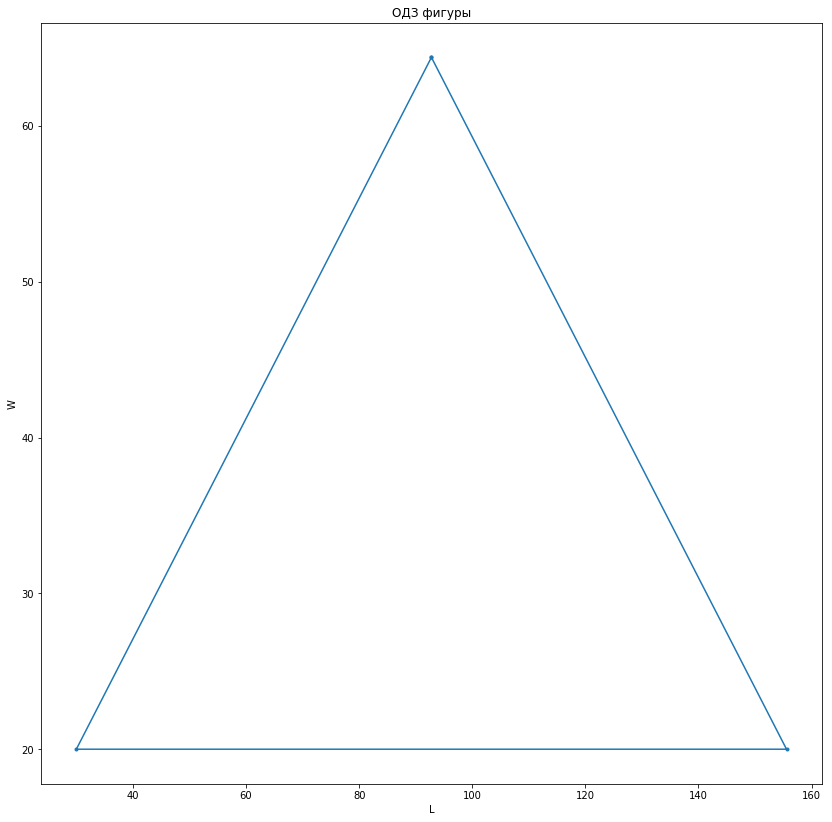

In [218]:
points_bounds = np.array([[15+55*np.sqrt(2),75-15/np.sqrt(2)],
          [30.,20.],
          [110*np.sqrt(2),20.],
          [15+55*np.sqrt(2),75-15/np.sqrt(2)]])
plt.figure(figsize=(14,14))
plt.plot(points_bounds[:,0],points_bounds[:,1],'.-')
plt.xlabel('L')
plt.ylabel('W')
plt.title('ОДЗ фигуры')

In [346]:
def create_test_points():
    s=50
    X,Y = np.meshgrid(np.linspace(points_bounds[1,0],points_bounds[2,0],s),np.linspace(points_bounds[1,1],points_bounds[0,1],s))
    inner = np.vstack((X.ravel(),Y.ravel())).T
    return inner

In [259]:
def in_border(p,pb):
    delta = 0.1
    p1 = pb[0]
    p2 = pb[1]
    p3 = pb[2]
    mask1 = p[:,1]+delta<line(p1,p2,p[:,0])
    mask2 = p[:,1]+delta<line(p1,p3,p[:,0])
    mask3 = p[:,1]-delta>pb[:,1].min()
    return mask1 & mask2 & mask3

In [347]:
test_points = create_test_points()
test_points = test_points[in_border(test_points,points_bounds)]

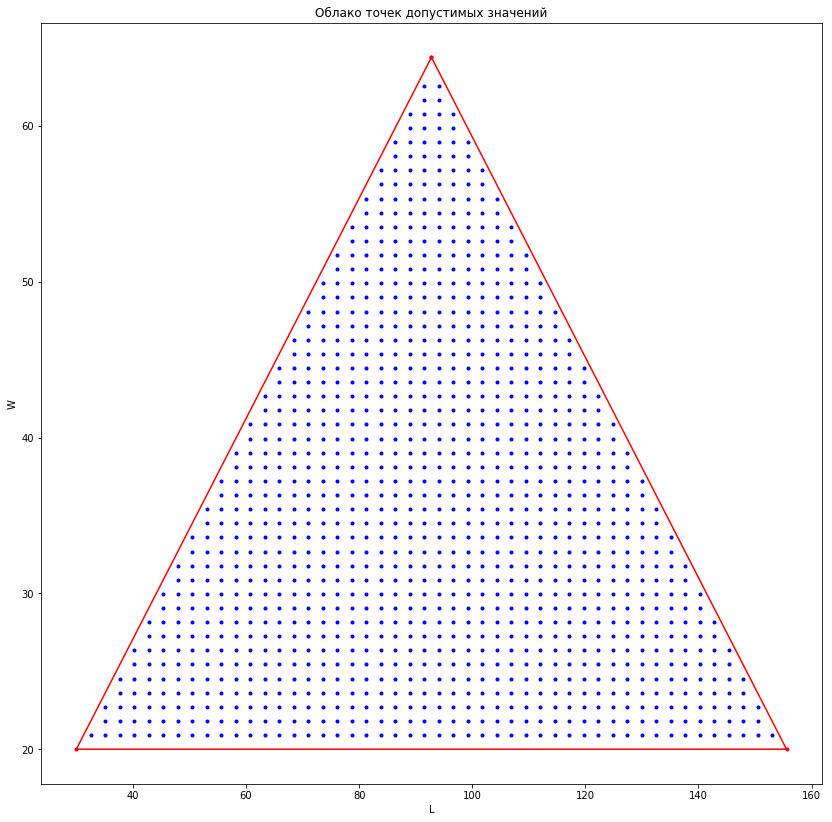

In [348]:
points_bounds = np.array([[15+55*np.sqrt(2),75-15/np.sqrt(2)],
          [30.,20.],
          [110*np.sqrt(2),20.],
          [15+55*np.sqrt(2),75-15/np.sqrt(2)]])
plt.figure(figsize=(14,14))
plt.plot(points_bounds[:,0],points_bounds[:,1],'.-r')
plt.plot(test_points[:,0],test_points[:,1],'.b')
plt.xlabel('L')
plt.ylabel('W')
plt.title('Облако точек допустимых значений')

In [349]:
trng1 = scipy.spatial.Delaunay(test_points)

In [141]:
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [396]:
def FEM(nodes, simplices,e,mu,t,dens,area,p,fixed_elems,force_elems,alpha):
    # расчет матрицы градиентов
    trng_vertices2 = nodes[simplices] # Пересчитаем, т.к. надо учитывать маски
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2])
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1],0] - trng_vertices2[:,[1,2,0],0]
    z = np.zeros_like(b[:,0])
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1)
    
    # расчет глобальной матрицы жесткости
    coef = 1/(2*A)
    B *= coef.reshape(-1, 1, 1)
    D = e / (1 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    dof = np.hstack((fixed_elems*2, fixed_elems*2+1))
    K[dof,:] = 0
    K[:,dof] = 0
    K[dof,dof] = 1
    
    # расчет силы, действующей на элементы
    F = np.zeros(2*Nn)
    #edges_L = np.sqrt(np.sum((nodes[force_elems[1:]]-nodes[force_elems[:-1]])**2,axis=1))
    edges_F = np.ones((len(force_elems)-1,)) * p
    #print(edges_F.shape)
    
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    
    F[force_elems[1: ]*2]+=0.5*edges_F*cos_alpha
    F[force_elems[:-1]*2]+=0.5*edges_F*cos_alpha
        
    F[force_elems[1: ]*2+1]+=0.5*edges_F*sin_alpha
    F[force_elems[:-1]*2+1]+=0.5*edges_F*sin_alpha
    
    F[dof] = 0
    
    # расчет перемещений
    U = np.linalg.solve(K, F)
    
    # расчет напряжений и главных напряжений
    Ue = U[EFT, None]
    Eps = np.matmul(B, Ue)
    Sig = np.matmul(D, Eps)
    NodeA = np.zeros((Nn,1))
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    NodeS2 = 0.5*(NodeSig[:,0]+NodeSig[:,1])-\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    NodeSe = NodeS1 - mu*NodeS2
    return U, NodeSe, area*t*dens

In [205]:
def plot_contour_map(ResNodes, NodeS1,simplices,fixed_elems,force_elems):
    i_max = np.argmax(NodeS1)
    i_min = np.argmin(NodeS1)
    plt.figure(figsize=(16,8))
    levels = np.linspace(NodeS1[i_min], NodeS1[i_max], 20)
    handle = plt.tricontourf(ResNodes[:,0], ResNodes[:, 1], simplices, NodeS1.ravel(), cmap='jet',levels=levels)
    plt.tricontour(ResNodes[:, 0], ResNodes[:, 1], simplices, 
                  NodeS1.ravel(), colors='k', levels=levels)
    plt.plot(ar1[:236,0],ar1[:236,1],'-r',)
    plt.plot(ResNodes[i_max,0], ResNodes[i_max,1], '.r')
    plt.text(ResNodes[i_max,0], ResNodes[i_max,1], ' %.2f'%NodeS1[i_max],fontsize=20)
    plt.plot(ResNodes[i_min,0], ResNodes[i_min,1], '.r')
    plt.text(ResNodes[i_min,0], ResNodes[i_min,1], ' %.2f'%NodeS1[i_min],fontsize=20)
    
    
    for elem in fixed_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.k')
        plt.text(ResNodes[elem,0],ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)
    
    for elem in force_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.r')
        plt.text(ResNodes[elem,0]-2.5,ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)

    cb = plt.gcf().colorbar(handle)
    cb.set_ticks(levels)
    plt.title('Поле главных напряжений в узлах, Н/см$^2$')
    plt.xlabel('X, см')
    plt.ylabel('Y, см')
    plt.axis('equal')
    #plt.ylim((-11.5,0.5))

In [397]:
def calc_specs(L,W,angle):
    mu1 = 0.27
    e1 = 2e7
    p1 = 1e3
    t1 = 1
    dens1 = 68e-4
    nodes, simplices,area,fixed,forced = create_fig(L,W)
    U, NodeSe, Mass = FEM(nodes,simplices,e1,mu1,t1,dens1,area,p1,fixed,forced,angle)
    max_sig = max(NodeSe.min(),NodeSe.max(),key=abs)
    return max_sig, Mass

In [293]:
from IPython.display import clear_output

In [294]:
import pickle

In [398]:
mass = []
sig = []
ll = test_points.shape[0]
for i,point in enumerate(test_points):
    s11,m11 = calc_specs(point[0],point[1],0.0)
    mass.append(m11)
    sig.append(s11)
    print('{}/{}'.format(i+1,ll))
    clear_output(wait=True)
with open('masses.bin','wb') as mf:
    pickle.dump(mass,mf)
with open('sigmas.bin','wb') as sf:
    pickle.dump(sig,sf)

1152/1152


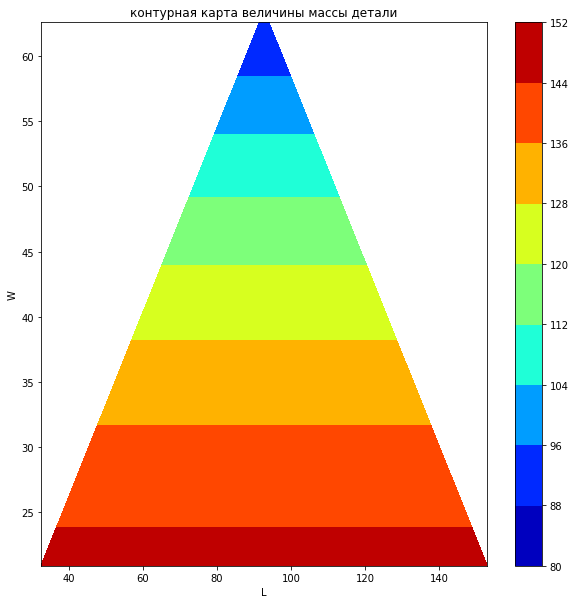

In [399]:
plt.figure(figsize=(10,10))
plt.tricontourf(test_points[:, 0], test_points[:, 1], trng1.simplices, 
                  mass, cmap='jet')
plt.colorbar()
plt.xlabel('L')
plt.ylabel('W')
plt.title('контурная карта величины массы детали')

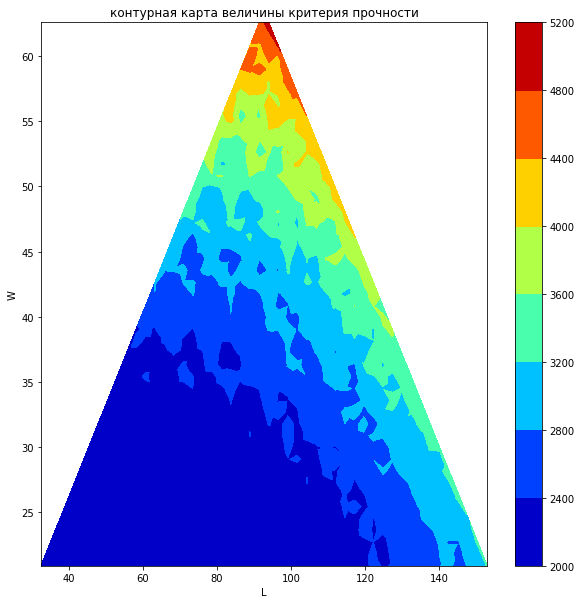

In [400]:
plt.figure(figsize=(10,10))
plt.tricontourf(test_points[:, 0], test_points[:, 1], trng1.simplices, 
                  sig, cmap='jet')
plt.colorbar()
plt.xlabel('L')
plt.ylabel('W')
plt.title('контурная карта величины критерия прочности')

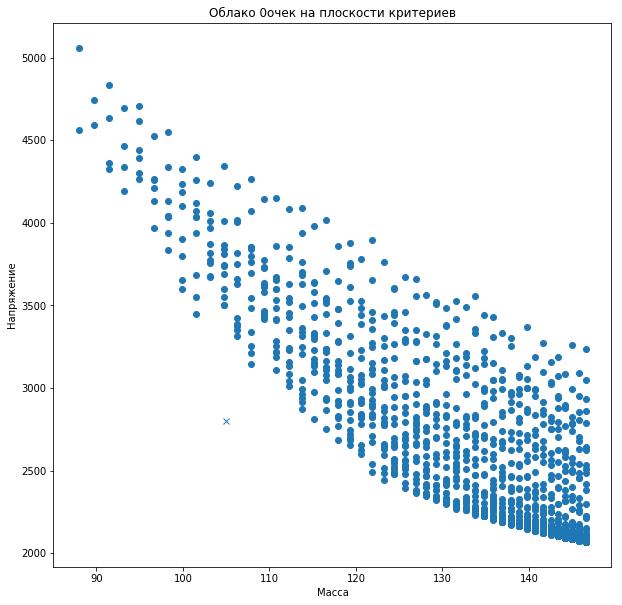

In [418]:
plt.figure(figsize=(10,10))
plt.scatter(mass,sig)
plt.xlabel('Масса')
plt.ylabel('Напряжение')
plt.title('Облако 0очек на плоскости критериев')
plt.plot(105,2800,'x')

In [407]:
def opt_func(L,W,mp,sp,lst=[]):
    lst.append([L,W])
    if in_border(np.array([[L,W]]),points_bounds)[0]:
        s,m = calc_specs(L,W,0.0)
        return np.abs(m-mp)+np.abs(s-sp)
    else:
        return 1e20

In [421]:
M, S = np.meshgrid(np.linspace(90.,105.,5),np.linspace(2000.,2800.,5))
perfect_points = np.vstack((M.ravel(),S.ravel())).T

In [ ]:
rez = []
for point in perfect_points:
    lst = []
    ret = scipy.optimize.minimize(lambda x, mp, sp, lst: opt_func(x[0], x[1],mp, sp, lst), [100., 40.],
                  args=(point[0],point[1], lst),
                  method='Nelder-Mead',
                  options={'xatol':1e-2, 'disp': True, 'maxiter':1000})
    rez.append(ret['x'])
with open('rez.bin','wb') as mf:
    pickle.dump(rez,mf)

Optimization terminated successfully.
         Current function value: 654.712865
         Iterations: 95
         Function evaluations: 245


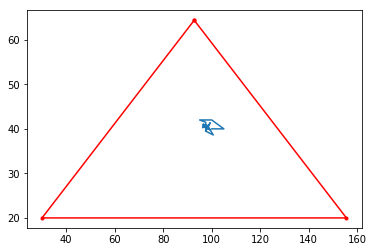

In [411]:
arr = np.array(lst)
plt.plot(arr[:,0],arr[:,1])
plt.plot(points_bounds[:,0],points_bounds[:,1],'.-r')

In [412]:
calc_specs(ret['x'][0],ret['x'][1],0.0)

(2619.933658686336, 124.77920664983557)